# Week 1 — Zero-Shot CLIP on EuroSAT (Baseline & Prompt Variants)

**Goal:** Reproduce a clean zero-shot baseline with CLIP/OpenCLIP on the EuroSAT (RGB) dataset, then test prompt variants and (optionally) a prompt ensemble.  
**Outputs:** Top-1/Top-5 accuracy, per-class accuracy, confusion matrix, and a CSV of results.

> Tip: Run this in **Google Colab** or on a local machine with a GPU. CPU works too (slower).

---

## Setup

**What this notebook does**
1. Installs dependencies (`open_clip_torch`, `datasets`, `torchvision`, etc.).  
2. Downloads **EuroSAT (RGB)** via Hugging Face Datasets.  
3. Loads an OpenCLIP model from the Hugging Face Hub (default: `ViT-B-32`).  
4. Evaluates zero-shot accuracy with multiple prompt templates.  
5. Logs metrics, plots a confusion matrix, and saves a CSV of results to `./results/`.

**You can customize**
- `MODEL_NAME` and `PRETRAINED` to pick larger models (e.g., ViT-L/14).  
- `PROMPT_TEMPLATES` to try your own prompts.  
- `BATCH_SIZE` for your hardware.  
- `SPLIT` (e.g., `'train'` vs `'test'` if you create your own split).

---

In [46]:
# If running in Colab, uncomment the next line to ensure a fresh install:
# !pip -q install --upgrade pip

# Core deps (adjust torch/torchvision to match your CUDA if installing locally)
# In Colab, this should "just work". On local machines, ensure torch matches your CUDA version.
!pip -q install open_clip_torch datasets torchvision pillow scikit-learn matplotlib tqdm


In [47]:
import os, math, json, random, time
from pathlib import Path
from typing import List, Dict, Tuple

import torch
import torchvision.transforms as T
from torchvision.transforms.functional import InterpolationMode
from PIL import Image

import open_clip
from datasets import load_dataset, DatasetDict
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, top_k_accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# Model config — change these to try other backbones/checkpoints
# MODEL_NAME = "ViT-B-32"  # must be an architecture from open_clip.list_models()
# PRETRAINED = "openai"  # or "laion2b_s34b_b79k"

MODEL_NAME = "ViT-L-14"; PRETRAINED = "laion2b_s32b_b82k" # better model for EuroSAT

# Data config
DATASET_NAME = "nielsr/eurosat-demo"

SPLIT = "train"            # EuroSAT has `train` only; we create a holdout below if desired
HOLDOUT_FRACTION = 0.2     # We'll create a small validation set for quick iteration

# Eval config
BATCH_SIZE = 64
NUM_WORKERS = 2  # has no effect here (datasets uses Python-level map), but kept for clarity

# Prompt templates
PROMPT_TEMPLATES = [
    "a satellite photo of {label}.",
    "an aerial view of {label}.",
    "a remote sensing image of {label}.",
    "a high-resolution satellite image of {label}.",
    "a Landsat-style satellite image of {label}.",
    "a Sentinel-2 style satellite image of {label}.",
    "overhead photo of {label}.",
    "aerial photograph of {label}.",
]

# Results dir
RESULTS_DIR = Path("results/zero_shot") / f"{MODEL_NAME}_{PRETRAINED}_{DATASET_NAME.replace('/', '_')}"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("Model:", MODEL_NAME, "| Pretrained:", PRETRAINED)
print("Results directory:", RESULTS_DIR.resolve())


Device: cuda
Model: ViT-L-14 | Pretrained: laion2b_s32b_b82k
Results directory: /home/oshri/code/clip-rs-fewshot/results/zero_shot/ViT-L-14_laion2b_s32b_b82k_nielsr_eurosat-demo


In [48]:
# Load EuroSAT (RGB)
ds: DatasetDict = load_dataset(DATASET_NAME)  # only 'train' exists; we'll split
print(ds)

# Create a stratified train/val split for evaluation repeatability
# This gives us: small "val" set to report metrics on, reproducibly.
ds = ds["train"].train_test_split(test_size=HOLDOUT_FRACTION, seed=SEED, stratify_by_column="label")
ds = DatasetDict({'train': ds['train'], 'val': ds['test']})
print(ds)

# Label names
label_names = ds["train"].features["label"].names
num_classes = len(label_names)
id2label = {i: n.replace("_", " ") for i, n in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

print("Classes:", num_classes)
print(id2label)


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 27000
    })
})
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 21600
    })
    val: Dataset({
        features: ['image', 'label'],
        num_rows: 5400
    })
})
Classes: 10
{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


In [49]:
# open_clip.list_models()

In [50]:
# Create model + preprocess from OpenCLIP
model, _, preprocess = open_clip.create_model_and_transforms(
    MODEL_NAME,
    pretrained=PRETRAINED,
    device=DEVICE
)
tokenizer = open_clip.get_tokenizer(MODEL_NAME)

# We'll use the provided `preprocess` for images. For text, we create tokenized prompts.
# Show preprocess pipeline for transparency
print(preprocess)
model.eval()

# warmup (optional)
with torch.no_grad():
    sz = getattr(getattr(model, "visual", None), "image_size", 224)
    if isinstance(sz, (tuple, list)):
        h, w = int(sz[0]), int(sz[1])
    else:
        h = w = int(sz)
    dummy = torch.zeros(1, 3, h, w, device=DEVICE)
    _ = model.encode_image(dummy)


Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb at 0x7ff3c94e0040>
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)


In [51]:
def build_text_tokens_for_template(template: str, classnames: List[str]) -> torch.Tensor:
    prompts = [template.format(label=cn) for cn in classnames]
    tok = tokenizer(prompts)
    return tok

# Cache tokenized prompts for all templates to avoid recompute
token_cache: Dict[str, torch.Tensor] = {}
for tmpl in PROMPT_TEMPLATES:
    token_cache[tmpl] = build_text_tokens_for_template(tmpl, [id2label[i] for i in range(num_classes)])
print("Prepared tokenized prompts for", len(PROMPT_TEMPLATES), "templates.")


Prepared tokenized prompts for 8 templates.


In [52]:
# The HF EuroSAT samples store PIL images in 'image' column and label indices in 'label'
def collate_batch(batch):
    images = [preprocess(x["image"]) for x in batch]
    labels = [x["label"] for x in batch]
    images = torch.stack(images, dim=0)
    labels = torch.tensor(labels, dtype=torch.long)
    return images, labels

def iterate_dataset(dset, batch_size=64):
    batch = []
    for ex in dset:
        batch.append(ex)
        if len(batch) == batch_size:
            yield collate_batch(batch)
            batch = []
    if batch:
        yield collate_batch(batch)


In [ ]:
@torch.no_grad()
def evaluate_zero_shot(dset, templates: List[str]):
    y_true = []
    y_pred = []
    y_logits = []
    top5_correct = 0
    n_total = 0

    # Precompute text features per template
    text_features_by_template = {}
    for tmpl in templates:
        tok = token_cache[tmpl].to(DEVICE)
        with torch.amp.autocast('cuda'):
            txt_feats = model.encode_text(tok)
        txt_feats = txt_feats / txt_feats.norm(dim=-1, keepdim=True)
        text_features_by_template[tmpl] = txt_feats

    for images, labels in tqdm(iterate_dataset(dset, BATCH_SIZE), total=math.ceil(len(dset)/BATCH_SIZE)):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        with torch.amp.autocast('cuda'):
            img_feats = model.encode_image(images)
        img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)

        # For each template: compute logits, keep separately
        logits_per_template = []
        for tmpl in templates:
            txt_feats = text_features_by_template[tmpl]
            logits = img_feats @ txt_feats.t()
            logits_per_template.append(logits)

        # Also compute ensemble by averaging logits across templates
        ensemble_logits = torch.stack(logits_per_template, dim=0).mean(dim=0)

        # Choose which set of logits you want to evaluate. We'll evaluate all (each template + ensemble).
        # For return, we'll keep the ensemble as "final", but we'll compute per-template metrics separately below.
        # First, compute top-1 predictions for ensemble:
        preds = ensemble_logits.argmax(dim=-1)
        y_true.extend(labels.tolist())
        y_pred.extend(preds.tolist())
        y_logits.append(ensemble_logits.detach().cpu())

        # Top-5 accuracy (ensemble)
        top5 = ensemble_logits.topk(5, dim=-1).indices
        top5_correct += (top5 == labels.unsqueeze(1)).any(dim=1).sum().item()
        n_total += labels.size(0)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_logits = torch.cat(y_logits, dim=0).numpy()

    acc_top1 = accuracy_score(y_true, y_pred)
    acc_top5 = top_k_accuracy_score(y_true, y_logits, k=5)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

    # Per-class accuracy
    per_class = {}
    for c in range(num_classes):
        idx = (y_true == c)
        per_class_acc = (y_pred[idx] == c).mean() if idx.any() else float('nan')
        per_class[id2label[c]] = float(per_class_acc)

    results = {
        "top1": float(acc_top1),
        "top5": float(acc_top5),
        "per_class": per_class,
        "confusion_matrix": cm.tolist(),
    }
    return results


In [54]:
all_results = {}

# Evaluate each template individually
for tmpl in PROMPT_TEMPLATES:
    print("\nEvaluating template:", tmpl)
    res_single = evaluate_zero_shot(ds["val"], [tmpl])
    all_results[f"single::{tmpl}"] = res_single
    print(f"Top-1: {res_single['top1']*100:.2f}% | Top-5: {res_single['top5']*100:.2f}%")

# Evaluate ensemble (averaging logits across all templates)
print("\nEvaluating ensemble (avg logits over all templates)")
res_ens = evaluate_zero_shot(ds["val"], PROMPT_TEMPLATES)
all_results["ensemble::avg"] = res_ens
print(f"Ensemble Top-1: {res_ens['top1']*100:.2f}% | Top-5: {res_ens['top5']*100:.2f}%")

# Save raw JSON
with open(RESULTS_DIR / "week1_zero_shot_results.json", "w") as f:
    json.dump(all_results, f, indent=2)
print("Saved:", (RESULTS_DIR / "week1_zero_shot_results.json").resolve())



Evaluating template: a satellite photo of {label}.


100%|██████████| 85/85 [00:23<00:00,  3.69it/s]


Top-1: 53.81% | Top-5: 90.39%

Evaluating template: an aerial view of {label}.


100%|██████████| 85/85 [00:23<00:00,  3.67it/s]


Top-1: 35.20% | Top-5: 89.19%

Evaluating template: a remote sensing image of {label}.


100%|██████████| 85/85 [00:23<00:00,  3.62it/s]


Top-1: 45.98% | Top-5: 86.52%

Evaluating template: a high-resolution satellite image of {label}.


100%|██████████| 85/85 [00:23<00:00,  3.64it/s]


Top-1: 53.96% | Top-5: 87.26%

Evaluating template: a Landsat-style satellite image of {label}.


100%|██████████| 85/85 [00:23<00:00,  3.65it/s]


Top-1: 52.87% | Top-5: 84.93%

Evaluating template: a Sentinel-2 style satellite image of {label}.


100%|██████████| 85/85 [00:23<00:00,  3.65it/s]


Top-1: 55.00% | Top-5: 85.81%

Evaluating template: overhead photo of {label}.


100%|██████████| 85/85 [00:23<00:00,  3.66it/s]


Top-1: 23.96% | Top-5: 94.39%

Evaluating template: aerial photograph of {label}.


100%|██████████| 85/85 [00:23<00:00,  3.64it/s]


Top-1: 44.15% | Top-5: 93.57%

Evaluating ensemble (avg logits over all templates)


100%|██████████| 85/85 [00:23<00:00,  3.66it/s]

Ensemble Top-1: 50.85% | Top-5: 91.91%
Saved: /home/oshri/code/clip-rs-fewshot/results/zero_shot/ViT-L-14_laion2b_s32b_b82k_nielsr_eurosat-demo/week1_zero_shot_results.json


In [55]:
import pandas as pd

rows = []
for key, res in all_results.items():
    rows.append({
        "setting": key,
        "top1": res["top1"],
        "top5": res["top5"],
    })
df = pd.DataFrame(rows).sort_values("top1", ascending=False)
display(df)

csv_path = RESULTS_DIR / "week1_zero_shot_summary.csv"
df.to_csv(csv_path, index=False)
print("Saved:", csv_path.resolve())


,setting,top1,top5
5,single::a Sentinel-2 style satellite image of ...,0.550000,0.858148
3,single::a high-resolution satellite image of {...,0.539630,0.872593
0,single::a satellite photo of {label}.,0.538148,0.903889
4,single::a Landsat-style satellite image of {la...,0.528704,0.849259
8,ensemble::avg,0.508519,0.919074
2,single::a remote sensing image of {label}.,0.459815,0.865185
7,single::aerial photograph of {label}.,0.441481,0.935741
1,single::an aerial view of {label}.,0.352037,0.891852
6,single::overhead photo of {label}.,0.239630,0.943889


Saved: /home/oshri/code/clip-rs-fewshot/results/zero_shot/ViT-L-14_laion2b_s32b_b82k_nielsr_eurosat-demo/week1_zero_shot_summary.csv


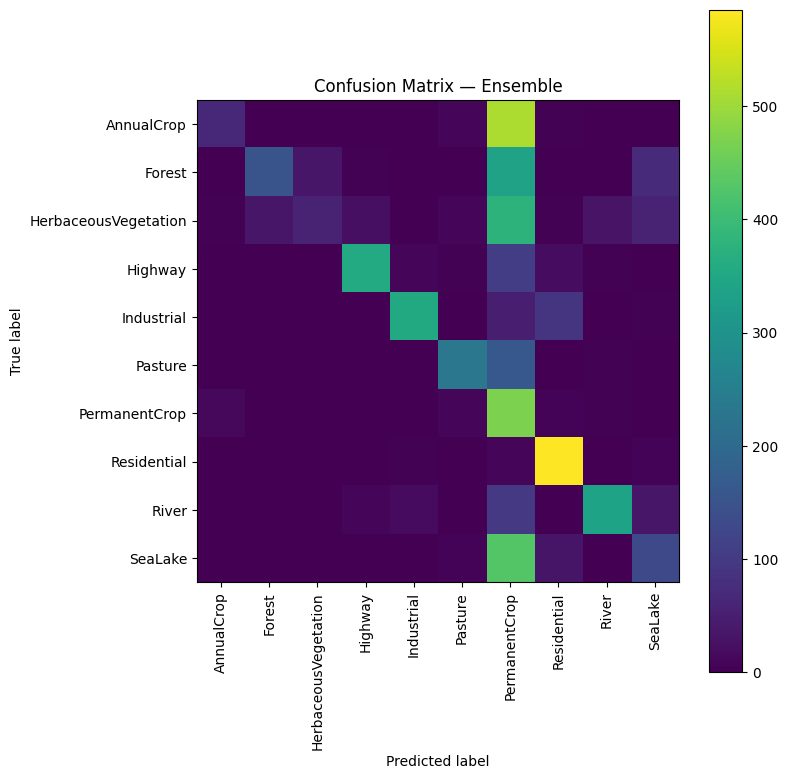

Saved: /home/oshri/code/clip-rs-fewshot/results/zero_shot/ViT-L-14_laion2b_s32b_b82k_nielsr_eurosat-demo/confusion_matrix_ensemble.png


In [56]:
# Plot confusion matrix for the ensemble
cm = np.array(all_results["ensemble::avg"]["confusion_matrix"])
fig = plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix — Ensemble")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, [id2label[i] for i in range(num_classes)], rotation=90)
plt.yticks(tick_marks, [id2label[i] for i in range(num_classes)])
plt.tight_layout()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()
fig_path = RESULTS_DIR / "confusion_matrix_ensemble.png"
fig.savefig(fig_path, bbox_inches='tight', dpi=200)
print("Saved:", fig_path.resolve())


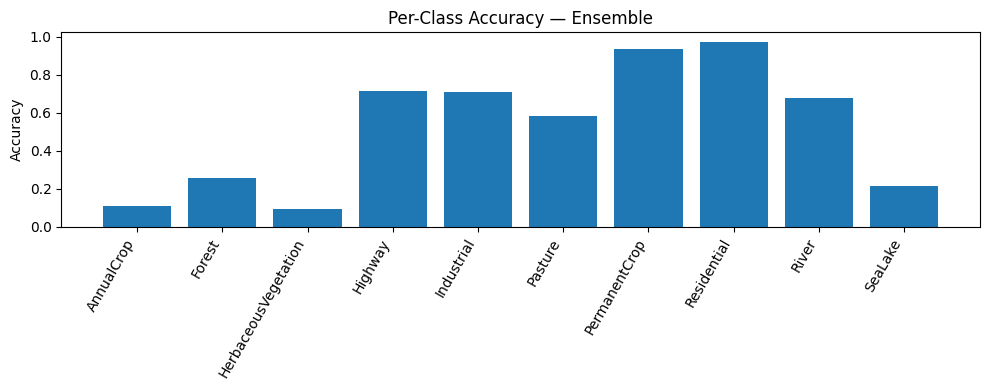

Saved: /home/oshri/code/clip-rs-fewshot/results/zero_shot/ViT-L-14_laion2b_s32b_b82k_nielsr_eurosat-demo/per_class_accuracy_ensemble.png


In [57]:
per_class = all_results["ensemble::avg"]["per_class"]
labels = list(per_class.keys())
values = [per_class[k] for k in labels]

fig = plt.figure(figsize=(10, 4))
plt.bar(labels, values)
plt.xticks(rotation=60, ha='right')
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy — Ensemble")
plt.tight_layout()
plt.show()
bar_path = RESULTS_DIR / "per_class_accuracy_ensemble.png"
fig.savefig(bar_path, bbox_inches='tight', dpi=200)
print("Saved:", bar_path.resolve())


In [58]:
meta = {
    "seed": SEED,
    "device": DEVICE,
    "model_name": MODEL_NAME,
    "pretrained": PRETRAINED,
    "dataset": {"name": DATASET_NAME},
    "split": SPLIT,
    "holdout_fraction": HOLDOUT_FRACTION,
    "batch_size": BATCH_SIZE,
    "num_workers": NUM_WORKERS,
    "prompt_templates": PROMPT_TEMPLATES,
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
}
with open(RESULTS_DIR / "metadata.json", "w") as f:
    json.dump(meta, f, indent=2)
print("Saved:", (RESULTS_DIR / "metadata.json").resolve())
meta


Saved: /home/oshri/code/clip-rs-fewshot/results/zero_shot/ViT-L-14_laion2b_s32b_b82k_nielsr_eurosat-demo/metadata.json


{'seed': 42,
 'device': 'cuda',
 'model_name': 'ViT-L-14',
 'pretrained': 'laion2b_s32b_b82k',
 'dataset': {'name': 'nielsr/eurosat-demo'},
 'split': 'train',
 'holdout_fraction': 0.2,
 'batch_size': 64,
 'num_workers': 2,
 'prompt_templates': ['a satellite photo of {label}.',
  'an aerial view of {label}.',
  'a remote sensing image of {label}.',
  'a high-resolution satellite image of {label}.',
  'a Landsat-style satellite image of {label}.',
  'a Sentinel-2 style satellite image of {label}.',
  'overhead photo of {label}.',
  'aerial photograph of {label}.'],
 'timestamp': '2025-10-19 08:07:29'}

## Notes & Expected Ranges

- On EuroSAT (RGB), **zero-shot** CLIP with a good prompt typically lands around **~50–60% top-1** (depends on model size and prompt quality).  
- **Prompt ensembles** (averaging logits) often give a small but consistent bump.  
- If your numbers are dramatically lower, check image preprocessing resolution, label strings, and that the dataset split is stratified.

## Next Steps (Week 2 Preview)
- Freeze the visual encoder and train a **linear probe** on k-shot subsets (k=5 or 10).  
- Optionally unfreeze the last transformer block for a short fine-tune.  
- Keep the same validation split for apples-to-apples comparisons.

---

**Artifacts saved** to `./results/`:
- `week1_zero_shot_results.json` — raw metrics per setting  
- `week1_zero_shot_summary.csv` — compact table (top-1/top-5)  
- `confusion_matrix_ensemble.png` — confusion matrix figure  
- `per_class_accuracy_ensemble.png` — per-class bar chart  
- `metadata.json` — run config
